# **Training Notebook for Santander Dataset**

Second Part: https://www.kaggle.com/akhilnasser/santander-customer-transaction-training-2

**Recommended: GPU**

## **1. Required Libraries & Setup**

In [1]:
!nvidia-smi

Tue Aug 17 08:01:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [3]:
# General Data Manipulation Libraries
import numpy as np; print('Numpy Version:', np.__version__)
import pandas as pd; print('Pandas Version:', pd.__version__)

# Model & Helper Libraries
import xgboost; print('XGBoost Version:', xgboost.__version__)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import torch; print('PyTorch Version:', torch.__version__)

# Plotting Tools
import matplotlib.pyplot as plt
import plotly; print('Plotly Version:', plotly.__version__)
from xgboost import plot_importance
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

# Hyper-parameter Optimization
import optuna; print('Optuna Version:', optuna.__version__)

Numpy Version: 1.19.5
Pandas Version: 1.2.4
XGBoost Version: 1.4.2
PyTorch Version: 1.7.0
Plotly Version: 5.1.0
Optuna Version: 2.8.0


In [4]:
if torch.cuda.is_available():
    import cudf; print('cuDF Version:', cudf.__version__)

cuDF Version: 21.06.01+2.g101fc0fda4


## **2. Short EDA of Data**

In [5]:
# Load Data
input_dir = '/kaggle/input/santander-customer-transaction-prediction/'
if torch.cuda.is_available():
    df_train = cudf.read_csv(input_dir + '/train.csv')
else:
    df_train = pd.read_csv(input_dir + '/train.csv')
df_train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [6]:
print(f'There are {len(df_train)} rows and {len(df_train.columns)} columns.')

There are 200000 rows and 202 columns.


In [7]:
df_train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [8]:
# Check for NaN values
print(f'Are there Nan values? {df_train.isnull().values.any()}')

Are there Nan values? False


Since there are no unique identifiable characteristics among the column labels we now proceed with the rest of the Data pipeline.

## **3. Data Preperation**

In [9]:
var_colums = [c for c in df_train.columns if c not in ['ID_code','target']]
X = df_train.loc[:, var_colums]
y = df_train.loc[:, 'target']

# We are performing a 80-20 split for Training and Validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((160000, 200), (40000, 200), (160000,), (40000,))

## **4. Model Setup & Training**

In [10]:
# View of Xgboost Parameters
xgboost.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### **4.1 XGBoost Parameter Selection**

1. Learning Rate: Weightage of each tree in the XGBoost Classifier.
2. Maximum Depth: The maximum depth of each tree in the XGBoost Classifier.
3. Number of Estimators: The Maximum number of trees to be created.
4. Subsample: The sampling percentage of the Training data used to create a Tree. Each Tree is trained on a new subsample of the trainign data.
5. Colsample By Tree: Percentage of Features to be used while building a tree in the model. Similar to Subsample. Each Tree is trained on a new subset of the original feature space.
6. Evaluation Metric: Evaluation Metric for the model.
7. Use Label Encoding: The target labels have to be encoded as integers startign with 0. This will be removed soon in a new release.
8. Verbosity: Verbosity of printing messages.
9. Early Stopping Rounds: The stopping Criteria for the training phase. If the Validation score does not improve for the specified number of iterations the training is stopped.

### **4.2 Cross-validation with XGBoost**

Refer: <a href = 'https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f'>Hyperparameter tuning in XGBoost</a>

The cross-validation function is splitting the train dataset into `nfolds` and iteratively keeps one of the folds for validation purposes. `cv` returns a table where the rows correspond to the number of boosting trees used. The 4 columns correspond to the mean and standard deviation of MAE on the validation dataset and on the train dataset.

In [11]:
# Model instantiation

# GPU Parameter
device_method = 'gpu_hist' if torch.cuda.is_available() else 'auto'
model_xgboost = xgboost.XGBClassifier(learning_rate=0.1,
                                      max_depth=5,
                                      n_estimators=5000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      use_label_encoder=False,
                                      tree_method = device_method,
                                      verbosity=1)
# Validation Set
eval_set = [(X_valid, y_valid)]

# Creating the DMatrix
d_matrix = xgboost.DMatrix(data=X_train, label=y_train)

xgb_param = model_xgboost.get_xgb_params()

cv_folds = 10
early_stopping_rounds = 10
# Cross-validation with 10 folds
cvresult = xgboost.cv(xgb_param, d_matrix, num_boost_round=model_xgboost.get_params()['n_estimators'], 
            nfold=cv_folds, metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

model_xgboost.set_params(n_estimators=cvresult.shape[0])

[0]	train-auc:0.62289+0.00169	test-auc:0.61269+0.00732
[1]	train-auc:0.66415+0.00351	test-auc:0.65345+0.00795
[2]	train-auc:0.69616+0.00263	test-auc:0.68235+0.00655
[3]	train-auc:0.71520+0.00300	test-auc:0.69971+0.00747
[4]	train-auc:0.72251+0.00449	test-auc:0.70468+0.00802
[5]	train-auc:0.73218+0.00327	test-auc:0.71306+0.00731
[6]	train-auc:0.73997+0.00305	test-auc:0.72170+0.00690
[7]	train-auc:0.74490+0.00323	test-auc:0.72590+0.00823
[8]	train-auc:0.75155+0.00219	test-auc:0.73239+0.00579
[9]	train-auc:0.75315+0.00260	test-auc:0.73318+0.00480
[10]	train-auc:0.75757+0.00190	test-auc:0.73693+0.00530
[11]	train-auc:0.76072+0.00208	test-auc:0.73954+0.00609
[12]	train-auc:0.76511+0.00225	test-auc:0.74297+0.00695
[13]	train-auc:0.76715+0.00173	test-auc:0.74457+0.00643
[14]	train-auc:0.77138+0.00210	test-auc:0.74843+0.00575
[15]	train-auc:0.77234+0.00203	test-auc:0.74889+0.00527
[16]	train-auc:0.77616+0.00219	test-auc:0.75204+0.00549
[17]	train-auc:0.77864+0.00224	test-auc:0.75376+0.00660
[1

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=None, verbosity=1)

In [12]:
# Training
model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,                  
                  verbose=True)

[0]	validation_0-auc:0.61709
[1]	validation_0-auc:0.65689
[2]	validation_0-auc:0.68299
[3]	validation_0-auc:0.70337
[4]	validation_0-auc:0.70872
[5]	validation_0-auc:0.71467
[6]	validation_0-auc:0.71893
[7]	validation_0-auc:0.72494
[8]	validation_0-auc:0.72889
[9]	validation_0-auc:0.73035
[10]	validation_0-auc:0.73449
[11]	validation_0-auc:0.73585
[12]	validation_0-auc:0.74199
[13]	validation_0-auc:0.74390
[14]	validation_0-auc:0.75016
[15]	validation_0-auc:0.75135
[16]	validation_0-auc:0.75178
[17]	validation_0-auc:0.75059
[18]	validation_0-auc:0.75508
[19]	validation_0-auc:0.75807
[20]	validation_0-auc:0.75882
[21]	validation_0-auc:0.76000
[22]	validation_0-auc:0.76217
[23]	validation_0-auc:0.76319
[24]	validation_0-auc:0.76739
[25]	validation_0-auc:0.77050
[26]	validation_0-auc:0.77221
[27]	validation_0-auc:0.77473
[28]	validation_0-auc:0.77751
[29]	validation_0-auc:0.77911
[30]	validation_0-auc:0.78283
[31]	validation_0-auc:0.78578
[32]	validation_0-auc:0.78631
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=2,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='gpu_hist',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [13]:
# Print Results
print("AUC Train Mean Score: {:.4f} with Standard Deviation {:.4f}\nAUC Valid Mean Score: {:.4f} with Standard Deviation {:.4f}".format(cvresult['train-auc-mean'].iloc[-1],
                                                    cvresult['train-auc-std'].iloc[-1], cvresult['test-auc-mean'].iloc[-1], cvresult['test-auc-std'].iloc[-1]))

AUC Train Mean Score: 0.9750 with Standard Deviation 0.0003
AUC Valid Mean Score: 0.8862 with Standard Deviation 0.0038


In [14]:
# Print Results on Test-Data
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]

if torch.cuda.is_available():
    y_train = y_train.to_array()
    y_valid = y_valid.to_array()

print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.9684
AUC Test: 0.8896


### **4.3 Plot of Results of Training**

We have multiple choices for ranking feature Importance.

Refer: <a href = 'https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7'> The Multiple faces of ‘Feature importance’ in XGBoost </a>


* Gain:  Implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.
* Coverage: Metric means the relative number of observations related to this feature. How many times is this feature used in the classification process for all constructed trees. Expressed as a percentage for all features’ cover metrics.
* Frequency (R)/Weight (python): Percentage representing the relative number of times a particular feature occurs in the trees of the model. 

*The Gain is the most relevant attribute to interpret the relative importance of each feature.*

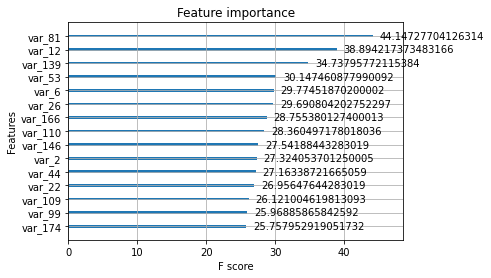

<Figure size 1800x1152 with 0 Axes>

In [15]:
# Feature Importance Plot
plot_importance(model_xgboost, max_num_features=15, importance_type='gain')
plt.figure(figsize = (25, 16))
plt.show()

## **5. Hyper-parameter Optimization**

In [16]:
def objective(trial, X_train, y_train, X_valid, y_valid):
    
    # Model Parameters to be optimized
    xgboost_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-7, 0.3, log=True),
        "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=2000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 8), 
        "subsample": trial.suggest_categorical(name="subsample", choices=[0.4, 0.5, 0.6]),
        "colsample_bytree": trial.suggest_categorical(name="colsample_bytree", choices=[0.4, 0.5, 0.6]),
        "random_state": 1121217
    }
    
    # Model Initialisation
    model_xgboost = xgboost.XGBClassifier(eval_metric='auc', use_label_encoder=False,
                                      tree_method = device_method, verbosity=0, **xgboost_params)
    eval_set = [(X_valid, y_valid)]
    
    # Model Training
    model_xgboost.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=False)
    
    # Model Prediction
    y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]
    
    # Optimization Metric    
    return roc_auc_score(y_valid, y_valid_pred)

In [17]:
# Create Study Object for Optuna
study = optuna.create_study(direction="maximize")
# Optimize
study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=100)

[I 2021-08-17 08:02:59,618] A new study created in memory with name: no-name-8cb7f3bf-237c-4002-a671-4ad713d20db8
[I 2021-08-17 08:03:29,358] Trial 0 finished with value: 0.8906606676751672 and parameters: {'learning_rate': 0.01829120400046912, 'n_estimators': 1100, 'max_depth': 8, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.8906606676751672.
[I 2021-08-17 08:03:29,710] Trial 1 finished with value: 0.6874187550266507 and parameters: {'learning_rate': 0.0002347268995941942, 'n_estimators': 1700, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.4}. Best is trial 0 with value: 0.8906606676751672.
[I 2021-08-17 08:03:30,827] Trial 2 finished with value: 0.7389561057515442 and parameters: {'learning_rate': 0.008680148202658, 'n_estimators': 1600, 'max_depth': 4, 'subsample': 0.4, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.8906606676751672.
[I 2021-08-17 08:03:31,446] Trial 3 finished with value: 0.6957648955650104 and parameters: {'learning_

In [18]:
print(f"Optimized roc_auc_score: {study.best_value:.5f}")

Optimized roc_auc_score: 0.89843


In [19]:
print("Best params:")

for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	learning_rate: 0.024254885373266786
	n_estimators: 1800
	max_depth: 5
	subsample: 0.6
	colsample_bytree: 0.5


### **5.1 Plots of Results**

In [20]:
# Check if Plotly library is available
optuna.visualization.is_available()

True

In [21]:
# Optimization History Plot
plot_optimization_history(study)

In [22]:
# Plot Hyperparameter Importance
plot_param_importances(study)